In [1]:
import gc
import os
import sys
import time
import math
import torch.nn as nn

import pandas as pd
import torch
from PIL import Image
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from torchvision import transforms
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
from collections import defaultdict
from itertools import product


warnings.filterwarnings("ignore", category=UserWarning)  # Disable UserWarnings
tqdm.pandas()

In [2]:
train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv("./dataset/test.csv")
validation_df = pd.read_csv("./dataset/val.csv")

In [3]:

# Compile the regular expression pattern
pattern = re.compile(r"[^a-z ]")


def text_preparetion(sentence):
    # 1. Lowercase everything
    sentence = sentence.lower()

    # 2. Remove all symbols other than a-z.
    sentence = re.sub(pattern, " ", sentence)

    return sentence

sentence1 = "A World War II-era bomber flying out of formation"
text_preparetion(sentence1)

'a world war ii era bomber flying out of formation'

In [4]:
train_df['preprocessed_text'] = train_df['caption'].progress_apply(text_preparetion)
validation_df['preprocessed_text'] = validation_df['caption'].progress_apply(text_preparetion)
test_df['preprocessed_text'] = test_df['caption'].progress_apply(text_preparetion)

100%|██████████| 2000/2000 [00:00<00:00, 655974.98it/s]


In [5]:
train_df

,id,caption,image_id,label,preprocessed_text
0,417812c5-0ce4-499d-b97d-4d28827239bc,Wet elephants shake water onto people bathing ...,394330,0,wet elephants shake water onto people bathing ...
1,5ac91fa3-55f2-4cb3-8c8f-ad84f78e6b36,Two men holding tennis racquets on the court,130849,0,two men holding tennis racquets on the court
2,d2705b90-8347-4cab-a7a6-654540d9a489,A bird on a tree limb with mountains in the ba...,514790,0,a bird on a tree limb with mountains in the ba...
3,a3b33fe7-3085-4433-9c18-8814803891b4,A kitchen and dining room are featured along w...,182096,0,a kitchen and dining room are featured along w...
4,1514b0e4-0665-45bc-ab32-52fce326cc29,A fruit stand has various fruits on the table.,68788,1,a fruit stand has various fruits on the table
...,...,...,...,...,...
9995,1d1df243-485d-4b29-82c8-7e34c0de1f5c,Several people stand in a field flying a kite.,522702,0,several people stand in a field flying a kite
9996,f7dfa883-e524-4974-b5ba-6b3c3db49087,A batter hitting a pitch at a baseball game.,441874,1,a batter hitting a pitch at a baseball game
9997,602e83dc-6539-4c1a-8d19-c1481b5c24bf,A person on white surfboard next to group in a...,166716,0,a person on white surfboard next to group in a...
9998,d9ce2e8c-0831-466a-8756-4c40d772b1ce,A baseball player getting ready to swing at th...,517601,0,a baseball player getting ready to swing at th...


In [6]:


def build_simple_vocab(sentences, special_tokens=None):
    """
    Manually create a vocabulary from a list of tokenized sentences.
    
    Args:
        sentences (list of str): List of sentences to build vocabulary from.
        special_tokens (list of str): Special tokens like <pad>, <unk>.
        
    Returns:
        dict: A vocabulary mapping tokens to indices.
        dict: An inverse vocabulary mapping indices to tokens.
    """
    special_tokens = special_tokens or ['<pad>', '<unk>']
    vocab = defaultdict(lambda: len(vocab))  # Default index is the current vocab size
    for token in special_tokens:
        vocab[token]  # Add special tokens first
    
    # Add tokens from sentences
    for sentence in sentences:
        for token in sentence.split():
            if token.strip():  # Exclude empty tokens
                vocab[token]
    
    # Convert to a normal dict (no longer dynamic)
    vocab = dict(vocab)
    inverse_vocab = {index: token for token, index in vocab.items()}
    return vocab, inverse_vocab


# Vectorize a sentence
def vectorize_sentence(sentence, vocab):
    """
    Converts a sentence into a tensor of token indices using a given vocabulary,
    ignoring empty tokens.
    
    Args:
        sentence (str): Input sentence.
        vocab (Vocab): Vocabulary to map tokens to indices.
        
    Returns:
        torch.Tensor: Vectorized sentence as a tensor.
    """
    # Ensure '<unk>' exists in the vocabulary
    unk_idx = vocab.get('<unk>', -1)
    if unk_idx == -1:
        raise ValueError("The vocabulary must include '<unk>' for unknown tokens.")

    # Split sentence into tokens and map them to indices
    tokens = [token for token in sentence.split() if token.strip()]
    return torch.tensor([vocab.get(token, unk_idx) for token in tokens], dtype=torch.long)


# Custom Dataset Class
class PreprocessingDataset(Dataset):
    def __init__(self, dataframe, vocab, images_path, train=True, max_len=None):
        """
        Dataset for preprocessing image-text pairs.

        Args:
            dataframe (pd.DataFrame): DataFrame containing 'image_id', 'sentence', and optionally 'label'.
            vocab (Vocab): Vocabulary for text vectorization.
            train (bool): Whether this is a training dataset.
            max_len (int): Maximum length for sentences. If None, no truncation.
        """
        super().__init__()
        self.dataframe = dataframe
        self.vocab = vocab
        self.train = train
        self.max_len = max_len
        self.images_path = images_path

        # Define image transformations
        self.image_transform = transforms.Compose([
            transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Process sentence
        sentence = row['caption']
        vectorized_sentence = vectorize_sentence(sentence, self.vocab)

        # Pad or truncate the sentence
        if len(vectorized_sentence) < self.max_len:
            padding_length = self.max_len - len(vectorized_sentence)
            pad_tensor = torch.full((padding_length,), self.vocab['<pad>'], dtype=torch.long)
            vectorized_sentence = torch.cat((vectorized_sentence, pad_tensor), dim=0)
        else:
            vectorized_sentence = vectorized_sentence[:self.max_len]

        # Process image
        image_path = f"{self.images_path}{row['image_id']}.jpg"
            
        try:
            image = Image.open(image_path).convert("RGB")  # Convert to RGB
            image = self.image_transform(image)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found at path: {image_path}")

        # Handle labels (for training)
        if self.train:
            label = row['label']
            label = torch.tensor(label, dtype=torch.long)
            return {
                'images': image,
                'captions': vectorized_sentence,
                'labels': label
            }
        else:
            return {
                'images': image,
                'captions': vectorized_sentence,
                'id': row['id']
            }

In [7]:
tokenized_sentence = [sentence.split(" ") for sentence in train_df['preprocessed_text']]
max_len = max(len([token for token in sentence.split(" ")]) for sentence in train_df['preprocessed_text'])
print(max_len)
vocab, inverse_vocab = build_simple_vocab(train_df['preprocessed_text'])

53


In [8]:
train_dataset = PreprocessingDataset(train_df, vocab, train=True, max_len=max_len, images_path = "./dataset/train_images/")
test_dataset = PreprocessingDataset(test_df, vocab, train=False, max_len=max_len, images_path = "./dataset/test_images/")
val_dataset = PreprocessingDataset(validation_df, vocab, train=True, max_len=max_len, images_path = "./dataset/val_images/")

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True )
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class CNN(nn.Module):
    def __init__(self, cnn_dropout_value):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(cnn_dropout_value),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(cnn_dropout_value),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(cnn_dropout_value),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.flatten = nn.Flatten()

    def forward(self, images):
        img_features = self.layers(images)  # (Batch, 128, 1, 1)
        img_features = self.flatten(img_features)  # (Batch, 128)
        return img_features


In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len):
        super(PositionalEncoding, self).__init__()
        # Create a matrix of shape (max_len, embedding_dim) for positional encodings
        position = torch.arange(0, max_len).unsqueeze(1)  # Shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-math.log(float(max_len)) / embedding_dim))
        
        pe = torch.zeros(max_len, embedding_dim)  # Shape: (max_len, embedding_dim)
        pe[:, 0::2] = torch.sin(position * div_term)  # Sin for even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Cos for odd indices
        
        pe = pe.unsqueeze(0)  # Add batch dimension: (1, max_len, embedding_dim)
        self.register_buffer('pe', pe)  # Register as non-learnable buffer

    def forward(self, x):
        """
        Add positional encoding to the input embeddings.
        x: (Batch, SeqLen, EmbeddingDim)
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :].to(x.device)

In [13]:
class TextModule(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, transformer_hidden_dim, num_transformer_layers, seq_len, transformer_dropout_value):
        super(TextModule, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=vocab["<pad>"])
        self.positional_encoding = PositionalEncoding(embedding_dim=embedding_dim, max_len=seq_len)
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embedding_dim,
                nhead=num_heads,
                dim_feedforward=transformer_hidden_dim,
                dropout=transformer_dropout_value,
                activation='relu'
            ),
            num_layers=num_transformer_layers
        )

    def forward(self, captions):
        embedded_captions = self.embedding(captions)  # (Batch, SeqLen, EmbeddingDim)
        pos_encoded_captions = self.positional_encoding(embedded_captions)  # Apply positional encoding
        
        # Transformer expects input shape (SeqLen, Batch, EmbeddingDim)
        transformer_input = pos_encoded_captions.permute(1, 0, 2)  # (SeqLen, Batch, EmbeddingDim)
        transformer_output = self.transformer_encoder(transformer_input)  # (SeqLen, Batch, EmbeddingDim)
        text_features = transformer_output.mean(dim=0)  # Mean pooling over SeqLen: (Batch, EmbeddingDim)
        return text_features

In [14]:
class Head(nn.Module):
    def __init__(self, image_feature_dim, text_feature_dim, transformer_dropout_value, num_classes):
        super(Head, self).__init__()
        self.fc1 = nn.Linear(image_feature_dim + text_feature_dim, 256)  # Combine image + text features
        self.dropout = nn.Dropout(transformer_dropout_value)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, img_features, text_features):
        combined_features = torch.cat((img_features, text_features), dim=1)  # (Batch, 128 + EmbeddingDim)
        x = F.relu(self.fc1(combined_features))  # (Batch, 256)
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # (Batch, num_classes)
        return x.squeeze(1)  # Logits (not probabilities)

In [15]:
class ImageTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, transformer_hidden_dim, num_transformer_layers, seq_len, cnn_dropout_value, transformer_dropout_value, num_classes=1):
        super(ImageTextClassifier, self).__init__()
        self.cnn = CNN(cnn_dropout_value)
        self.text_module = TextModule(
            vocab_size, embedding_dim, num_heads,
            transformer_hidden_dim, num_transformer_layers,
            seq_len, transformer_dropout_value
        )
        self.head = Head(image_feature_dim=128, text_feature_dim=embedding_dim, transformer_dropout_value=transformer_dropout_value, num_classes=num_classes)

    def forward(self, images, captions):
        img_features = self.cnn(images)  # Image feature extraction
        text_features = self.text_module(captions)  # Text feature extraction
        return self.head(img_features, text_features)  # Classification

In [16]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.TransformerEncoderLayer):
        for name, param in m.named_parameters():
            if "weight" in name:
                if param.dim() > 1:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.ones_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

In [17]:
# # Test model code
model = ImageTextClassifier(
    vocab_size=10000,  # Example parameters
    embedding_dim=128,
    num_heads=8,
    transformer_hidden_dim=512,
    num_transformer_layers=6,
    seq_len=max_len,
    cnn_dropout_value=0.3,
    transformer_dropout_value=0.3,
    num_classes=1
)

# Apply weight initialization recursively
model.apply(initialize_weights)

# Dummy input data
images = torch.randn(16, 3, 100, 100)  # Batch of 16 RGB images of size 224x224
captions = torch.randint(0, len(vocab), (16, max_len))  # Batch of 16 captions with max_len tokens each

output = model(images, captions)
print(output.shape)  # Should be (16) 

torch.Size([16])


In [18]:
# Initialize the model
model_config = {
    "vocab_size": len(vocab),
    "embedding_dim": 128,
    "num_heads": 2,
    "transformer_hidden_dim": 256,
    "num_transformer_layers": 2,
    "seq_len": max_len,
    "cnn_dropout_value": 0.4,
    "transformer_dropout_value": 0.5,
}
model = ImageTextClassifier(**model_config)
model.to(device)
model.apply(initialize_weights)

ImageTextClassifier(
  (cnn): CNN(
    (layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.4, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Dropout(p=0.4, inplace=False)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): Dropout(p=0.4, inplace=False)
      (14): AdaptiveAvgPool2d(output_size=(1, 1))
    )
    (flatten): Flatten(st

In [19]:
criterion = nn.BCEWithLogitsLoss()  # Use logits directly
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
 # T_0 -> Number of iterations until the first restart
 # T_mult -> Double the cycle length after every restart
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=5,  # Number of epochs before the first restart
    T_mult=2,  # Multiplicative factor for increasing restart period
    eta_min=1e-6  # Minimum learning rate
)

In [20]:
import copy

def training_method(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader, patience=50, delta = 0.01, loss_procentage_improvement=10):
    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    val_accuracies = []  # List to store validation accuracies
    val_precisions = []  # List to store validation precisions
    val_recalls = []  # List to store validation recalls
    val_f1s = []  # List to store validation F1-scores
    learning_rates = [] # List to store learning rate progression

    best_val_loss = float('inf')  # Initialize the best validation loss
    initial_loss = float('inf')
    best_model = None  # Store the best model
    epochs_without_improvement = 0  # Track epochs without improvement

    for epoch in range(num_epochs):
        start_time = time.time()
        ### TRAINING
        model.train()
        training_loss = 0.0
        
        for batch in train_loader:
            images = batch['images'].to(device)      # Images from batch
            captions = batch['captions'].to(device)  # Captions from batch
            labels = batch['labels'].to(device).float()  # Binary labels (0/1), converted to float
            
            optimizer.zero_grad()  # Reset gradients
            output = model(images, captions)  # Forward pass (logits)
            loss = criterion(output, labels)  # Compute loss
            loss.backward()  # Backpropagation
            
            optimizer.step()  # Update weights
            training_loss += loss.item()  # Accumulate loss
            
        train_loss = training_loss / len(train_loader)  # Average training loss
        train_losses.append(train_loss)

        ### VALIDATING
        model.eval()
        validation_loss = 0.0
        all_labels = []  # Ground truth labels for validation
        all_preds = []   # Predictions for validation
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['images'].to(device)
                captions = batch['captions'].to(device)
                labels = batch['labels'].to(device).float()
                
                output = model(images, captions)  # Forward pass (logits)
                loss = criterion(output, labels)  # Compute validation loss
                validation_loss += loss.item()
                
                # Convert logits to probabilities and apply threshold
                preds = (torch.sigmoid(output) > 0.5).float()
                
                # Store for statistics
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                
        val_loss = validation_loss / len(val_loader)  # Average validation loss
        val_losses.append(val_loss)
        
        # Compute validation statistics
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_precision = precision_score(all_labels, all_preds, zero_division=0)
        val_recall = recall_score(all_labels, all_preds, zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        
        if epoch == 1:
            initial_loss = val_loss

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)  # Save the best model
            epochs_without_improvement = 0  # Reset counter
            print(f"New best model with Loss: {val_loss:.4f} at epoch {epoch + 1}")
        elif val_loss < best_val_loss - delta:
            print(f"Validation loss did not improve significantly")            
        else:
            epochs_without_improvement += 1
            print(f"Validation loss did not improve for {epochs_without_improvement} epoch(s).")
            # Stop training if validation loss does not improve for 'patience' epochs
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Loss: {best_val_loss:.4f}")
                break  # Exit training loop


        # Step the learning rate scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']  # Get the current learning rate
        learning_rates.append(current_lr)
        end_time = time.time()

        print(f"\nEpoch {epoch + 1}/{num_epochs} - "
              f"Training Loss: {train_loss:.4f} - "
              f"Validation Loss: {val_loss:.4f} - "
              f"Accuracy: {val_accuracy:.4f} - "
              f"Precision: {val_precision:.4f} - "
              f"Recall: {val_recall:.4f} - "
              f"F1 Score: {val_f1:.4f} - "
              f"Time: {end_time - start_time:.2f} - "
              f"Lr: {current_lr:.2e}")

    print('Training finished!')
    
    # save the model only if the best loss is lower than the first initial loss ( to see that the model actually improved with 10% loss )
    if best_val_loss < (100 - loss_procentage_improvement) * initial_loss:
        # Init plot&model save path
        plt_save_path = "models/"
        model_config['eval_loss'] = best_val_loss
        for key, value in model_config.items():
            plt_save_path += key + "=" + str(value) + "+"
        plt_save_path = plt_save_path[:-1] + ".png"
        model_path = plt_save_path[:-4] + ".pt"
        
        torch.save(best_model.state_dict(), model_path)
        print(f"Best model with Loss: {best_val_loss:.4f} saved.")
        print(f"Model saved to {model_path}")

        # Plotting the losses and validation metrics over epochs
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        plt.subplot(3, 1, 2)
        plt.plot(val_accuracies, label='Accuracy')
        plt.plot(val_precisions, label='Precision')
        plt.plot(val_recalls, label='Recall')
        plt.plot(val_f1s, label='F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('Metric')
        plt.title('Validation Metrics')
        plt.legend()
        
        plt.subplot(3, 1, 3)
        plt.plot(learning_rates, label='Learning Rate')
        plt.xlabel("Epochs")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Progression")
        plt.legend()
    
        plt.tight_layout()
        plt.savefig(plt_save_path)
        plt.show()
    
    else:
        print(f"Model wasn't saved because it didn't improve: {loss_procentage_improvement}%")

New best model with Loss: 0.6917 at epoch 1

Epoch 1/50 - Training Loss: 0.7089 - Validation Loss: 0.6917 - Accuracy: 0.5187 - Precision: 0.5231 - Recall: 0.4227 - F1 Score: 0.4676 - Time: 25.02 - Lr: 9.14e-06
Validation loss did not improve for 1 epoch(s).

Epoch 2/50 - Training Loss: 0.7014 - Validation Loss: 0.6928 - Accuracy: 0.5077 - Precision: 0.5077 - Recall: 0.5040 - F1 Score: 0.5059 - Time: 25.09 - Lr: 6.89e-06
Validation loss did not improve for 2 epoch(s).

Epoch 3/50 - Training Loss: 0.7023 - Validation Loss: 0.6926 - Accuracy: 0.5153 - Precision: 0.5183 - Recall: 0.4340 - F1 Score: 0.4724 - Time: 24.51 - Lr: 4.11e-06
Validation loss did not improve for 3 epoch(s).

Epoch 4/50 - Training Loss: 0.6977 - Validation Loss: 0.6932 - Accuracy: 0.5047 - Precision: 0.5048 - Recall: 0.4893 - F1 Score: 0.4970 - Time: 24.52 - Lr: 1.86e-06
Validation loss did not improve for 4 epoch(s).

Epoch 5/50 - Training Loss: 0.6963 - Validation Loss: 0.6931 - Accuracy: 0.5090 - Precision: 0.5095

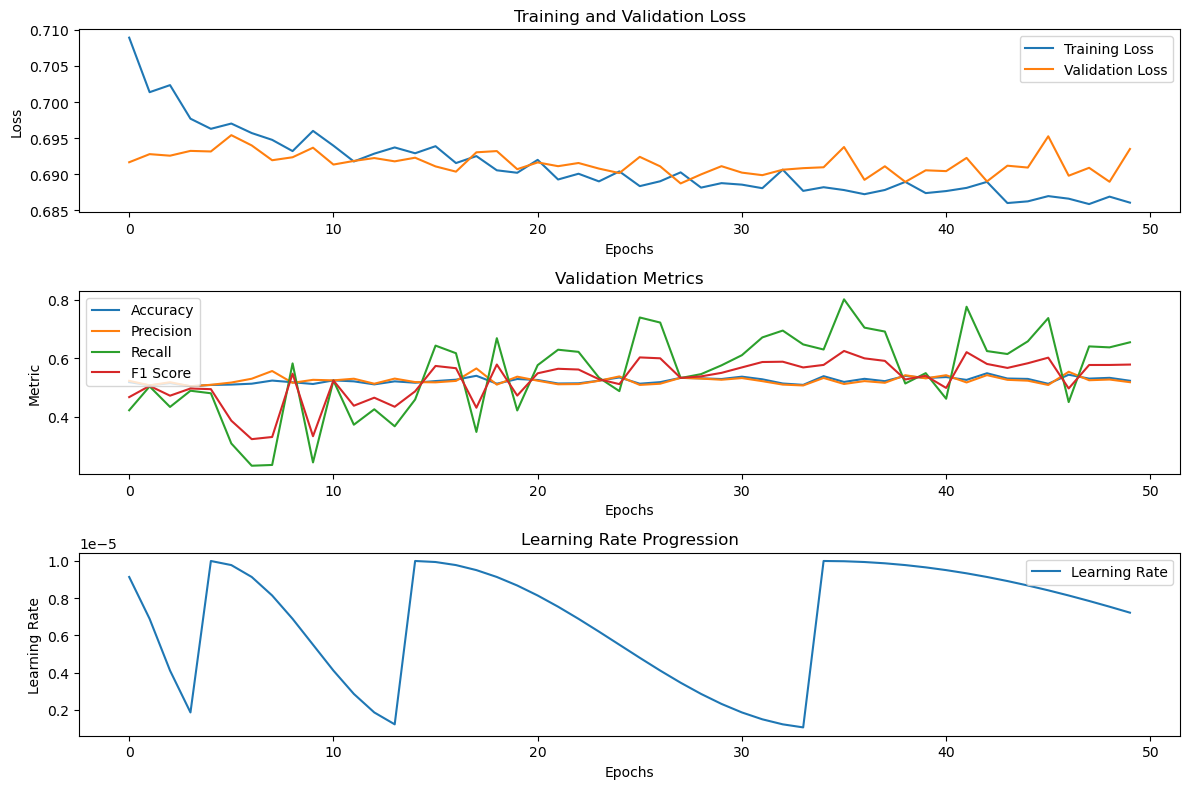

In [21]:
training_method(model, criterion, optimizer, scheduler, num_epochs=50, train_loader=train_dataloader, val_loader=val_dataloader)

In [41]:
ids = []
predictions = []

def make_submission(model, test_loader):
    model.eval()

    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            id = batch['id']
            
            output = model(images, captions)
            preds = (torch.sigmoid(output) > 0.5).int()
            
            ids.extend(id)
            predictions.extend(preds.cpu().tolist())
    df = pd.DataFrame({'id': ids, 'label': predictions})
    df.to_csv('submission2.csv', index=False)

In [42]:
# model_config = {
#     "vocab_size": len(vocab),
#     "embedding_dim": 128,
#     "num_heads": 2,
#     "transformer_hidden_dim": 256,
#     "num_transformer_layers": 2,
#     "seq_len": max_len,
#     "cnn_dropout_value": 0.4,
#     "transformer_dropout_value": 0.5,
# }
# model = ImageTextClassifier(**model_config)
# model_path = "models/vocab_size=3733+embedding_dim=128+num_filters=128+filter_sizes=[3, 4, 5, 6, 7, 8]+seq_len=53+cnn_text_drop_value=0.5+cnn_dropout_value=0.4+transformer_dropout_value=0.5+num_classes=1+eval_loss=0.6212541232717798.pt"
# model.load_state_dict(torch.load(model_path, weights_only=True))

RuntimeError: Error(s) in loading state_dict for ImageTextClassifier:
	Missing key(s) in state_dict: "text_module.transformer_encoder.layers.0.self_attn.in_proj_weight", "text_module.transformer_encoder.layers.0.self_attn.in_proj_bias", "text_module.transformer_encoder.layers.0.self_attn.out_proj.weight", "text_module.transformer_encoder.layers.0.self_attn.out_proj.bias", "text_module.transformer_encoder.layers.0.linear1.weight", "text_module.transformer_encoder.layers.0.linear1.bias", "text_module.transformer_encoder.layers.0.linear2.weight", "text_module.transformer_encoder.layers.0.linear2.bias", "text_module.transformer_encoder.layers.0.norm1.weight", "text_module.transformer_encoder.layers.0.norm1.bias", "text_module.transformer_encoder.layers.0.norm2.weight", "text_module.transformer_encoder.layers.0.norm2.bias", "text_module.transformer_encoder.layers.1.self_attn.in_proj_weight", "text_module.transformer_encoder.layers.1.self_attn.in_proj_bias", "text_module.transformer_encoder.layers.1.self_attn.out_proj.weight", "text_module.transformer_encoder.layers.1.self_attn.out_proj.bias", "text_module.transformer_encoder.layers.1.linear1.weight", "text_module.transformer_encoder.layers.1.linear1.bias", "text_module.transformer_encoder.layers.1.linear2.weight", "text_module.transformer_encoder.layers.1.linear2.bias", "text_module.transformer_encoder.layers.1.norm1.weight", "text_module.transformer_encoder.layers.1.norm1.bias", "text_module.transformer_encoder.layers.1.norm2.weight", "text_module.transformer_encoder.layers.1.norm2.bias". 
	Unexpected key(s) in state_dict: "text_module.conv_layers.0.weight", "text_module.conv_layers.0.bias", "text_module.conv_layers.1.weight", "text_module.conv_layers.1.bias", "text_module.conv_layers.2.weight", "text_module.conv_layers.2.bias", "text_module.conv_layers.3.weight", "text_module.conv_layers.3.bias", "text_module.conv_layers.4.weight", "text_module.conv_layers.4.bias", "text_module.conv_layers.5.weight", "text_module.conv_layers.5.bias", "text_module.conv_layers.6.weight", "text_module.conv_layers.6.bias", "text_module.fc.weight", "text_module.fc.bias". 

In [68]:
# make_submission(model, test_dataloader)

In [69]:

def hyperparameter_tuning(vocab_size, max_len, train_loader, val_loader, param_grid, training_method, num_epochs=200):

    # Create all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    for params in tqdm(param_combinations):
        print(f"Testing configuration: {params}")
        
        try:
            # Update model configuration
            model_config = {
                "vocab_size": vocab_size,
                "embedding_dim": params["embedding_dim"],
                "num_heads": params["num_heads"],
                "transformer_hidden_dim": params["transformer_hidden_dim"],
                "num_transformer_layers": params["num_transformer_layers"],
                "seq_len": max_len,
                "cnn_dropout_value": params["cnn_dropout_value"],
                "transformer_dropout_value": params["transformer_dropout_value"],
            }
            
            # Initialize model
            model = ImageTextClassifier(**model_config)
            model.to(device)
            model.apply(initialize_weights)
            
            # Define criterion, optimizer, and scheduler
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.AdamW(
                model.parameters(), 
                lr=params["lr"], 
                weight_decay=params["weight_decay"]
            )
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, 
                T_0=params["T_0"]
            )
            
            # Train the model
            training_method(
                model, criterion, optimizer, scheduler,
                num_epochs=num_epochs,
                train_loader=train_loader,
                val_loader=val_loader
            )
            print(f"Completed configuration: {params}")
        
        except RuntimeError as e:
            print(f"Error with configuration: {params}")
            print(f"Error message: {str(e)}")
        
        finally:
            # Reset GPU memory
            print("Resetting GPU memory...")
            torch.cuda.empty_cache()
            gc.collect()

In [70]:
param_grid = {
    "embedding_dim": [128],
    "num_heads": [2, 4],
    "transformer_hidden_dim": [256, 512],
    "num_transformer_layers": [2, 4, 6],
    "cnn_dropout_value": [0.3,0.5],
    "transformer_dropout_value": [0.5, 0.7],
    "lr": [1e-5],
    "weight_decay": [1e-4],
    "T_0": [10],
    "T_mult": [1],
    "eta_min": [5e-5],
}

total_combinations = math.prod(len(values) for values in param_grid.values())
print(f"Total combinations: {total_combinations}")

time_per_epoch = 10  # seconds
num_epochs = 200  # epochs per configuration
total_time_seconds = total_combinations * time_per_epoch * num_epochs

# Convert to hours
total_time_hours = total_time_seconds / 3600
print(f"Total time to hyper tune: {total_time_hours} hours")

Total combinations: 48
Total time to hyper tune: 26.666666666666668 hours


In [ ]:
results = hyperparameter_tuning(
    vocab_size=len(vocab),
    max_len=max_len,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    param_grid=param_grid,
    training_method=training_method,
    num_epochs=100
)

In [72]:
dir_models = os.listdir("./models")

In [73]:
best_models = [path[:-3] for path in dir_models if path.endswith(".pt")]

In [74]:
best_val_loss = [float(str(best_model.split("+")[-1:]).split("=")[1][:8]) for best_model in best_models]

In [75]:
best_val_loss.sort()
best_val_loss[:100]

[0.660337,
 0.664585,
 0.665792,
 0.668462,
 0.670021,
 0.672664,
 0.675811,
 0.681725,
 0.682481,
 0.684356,
 0.686619,
 0.687482,
 0.688138,
 0.689773,
 0.689816,
 0.690059,
 0.690433,
 0.690811,
 0.691084,
 0.691453,
 0.691687,
 0.691882,
 0.692092,
 0.692399,
 0.693083,
 0.69325,
 0.69375,
 0.69376,
 0.694388,
 0.694468,
 0.695002,
 0.695236,
 0.697659,
 0.701796,
 0.702709,
 0.70666,
 0.70896,
 0.712001,
 0.720319,
 0.72129,
 0.723137,
 0.725296,
 0.729258,
 0.737214,
 0.740286,
 0.749817,
 0.752434]